In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable, grad

In [90]:
print torch.__version__    # 0.4.0a0+ed64001

0.4.0a0+ed64001


In [91]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [124]:
alpha, beta = 1e-4, 1e-4
meta_batch_size = 32

In [93]:
class Net(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(1, 40)
        self.fc2 = nn.Linear(40, 40)
        self.fc3 = nn.Linear(40, 1)
        
    def forward(self, x):
        
        x = x.view(-1, 1)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        
        return x

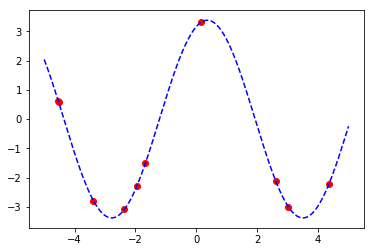

(Variable containing:
  0.1519
 -1.9502
  4.3607
 -1.6708
 -2.3655
 -4.5414
  3.0258
 -3.3817
 -4.5211
  2.6035
 [torch.FloatTensor of size 10], Variable containing:
  3.3063
 -2.2768
 -2.2066
 -1.5000
 -3.0907
  0.6346
 -3.0040
 -2.7890
  0.5670
 -2.1059
 [torch.FloatTensor of size 10])

In [94]:
def get_samples(k, show=True, net=None):
    
    def compute_sine(amp, phase, x):
        return amp * np.sin(x + phase)
    
    amp = np.random.uniform(0.1, 5.0)
    phase = np.random.uniform(0, np.pi)
    
    x = np.random.uniform(-5.0, 5.0, size=k)
    y = compute_sine(amp, phase, x)
    
    x_all = np.linspace(-5, 5, num=1000)
    y_all = compute_sine(amp, phase, x_all)
    
    if net is not None:
        y_net_all = net(Variable(torch.from_numpy(x_all).type(torch.FloatTensor), requires_grad=True))
        y_net_all = y_net_all.data.numpy()
    
    if show:
        plt.figure()
        plt.plot(x, y, 'ro')
        
        if net is not None:
            plt.plot(x_all, y_all, 'b--', x_all, y_net_all, 'g--')
        else:
            plt.plot(x_all, y_all, 'b--')
            
        plt.show()
        
    x, y = Variable(torch.from_numpy(x), requires_grad=True), Variable(torch.from_numpy(y))
    x, y = x.float(), y.float()
    
    return (x, y)

get_samples(10, show=True)

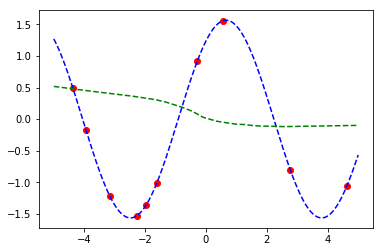

In [95]:
net = Net()
x, y = get_samples(10, show=True, net=net)
loss_criteria = nn.MSELoss()

In [84]:
output = net(x)
loss = loss_criteria(output, y)
print "Loss: ", loss.data[0]

Loss:  4.21541213989


In [9]:
# Compute d L(ftheta)/dtheta
net.zero_grad()
loss.backward(create_graph=True)

In [10]:
# Update model parameters
original_state = net.state_dict()
for W in net.parameters():
    W.data.sub_(alpha*W.grad.data)

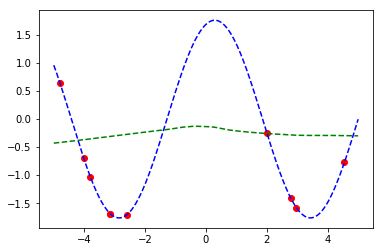

In [11]:
# Get parameters fro one step lookahead
x_new, y_new = get_samples(10, show=True, net=net)

In [12]:
output_lookahead = net(x_new)
loss = loss_criteria(output_lookahead, y_new)
grad_lookahead = grad(loss, net.parameters(), create_graph=True)
grad_lookahead = map(lambda x: Variable(x.data), grad_lookahead)

In [13]:
print type(grad_lookahead[0]), grad_lookahead[0].grad_fn

<class 'torch.autograd.variable.Variable'> None


In [14]:
for i, (n, W) in enumerate(net.named_parameters()):
    vjp = torch.sum(W.grad * grad_lookahead[i])
#     vjp.requires_grad = True
#     vjp.volatile = False
    
    hvp = grad(vjp, W, retain_graph=True)[0]

    print "Param: ", n
    print "W size: ",  W.size(), type(W)
    print "Beta: ", beta, " Alpha: ", alpha
    print "HVP size: ", hvp.size(), type(hvp)
    print "Original size: ", original_state[n].size()

    original_state[n] -= (beta*W.grad.data - alpha*hvp.data)

net.load_state_dict(original_state)

Param:  fc1.weight
W size:  torch.Size([40, 1]) <class 'torch.nn.parameter.Parameter'>
Beta:  0.01  Alpha:  0.01
HVP size:  torch.Size([40, 1]) <class 'torch.autograd.variable.Variable'>
Original size:  torch.Size([40, 1])
Param:  fc1.bias
W size:  torch.Size([40]) <class 'torch.nn.parameter.Parameter'>
Beta:  0.01  Alpha:  0.01
HVP size:  torch.Size([40]) <class 'torch.autograd.variable.Variable'>
Original size:  torch.Size([40])
Param:  fc2.weight
W size:  torch.Size([40, 40]) <class 'torch.nn.parameter.Parameter'>
Beta:  0.01  Alpha:  0.01
HVP size:  torch.Size([40, 40]) <class 'torch.autograd.variable.Variable'>
Original size:  torch.Size([40, 40])
Param:  fc2.bias
W size:  torch.Size([40]) <class 'torch.nn.parameter.Parameter'>
Beta:  0.01  Alpha:  0.01
HVP size:  torch.Size([40]) <class 'torch.autograd.variable.Variable'>
Original size:  torch.Size([40])
Param:  fc3.weight
W size:  torch.Size([1, 40]) <class 'torch.nn.parameter.Parameter'>
Beta:  0.01  Alpha:  0.01
HVP size:  tor

In [15]:
print list(net.named_parameters())

[('fc1.weight', Parameter containing:
 0.3776
 0.4947
-0.7980
 0.9925
 0.5800
 0.1819
-0.6825
 0.2747
-0.5608
-0.1394
 0.1098
-0.6013
 0.6517
 0.2797
 0.0188
-0.8725
-0.4822
-0.3238
-0.7807
-0.9663
-0.5344
 0.1630
-0.9407
-0.0556
-0.8519
-0.2712
 0.7415
 0.1503
-0.1661
-0.2526
 0.5220
-0.1843
 0.1355
 0.6084
 0.2410
-0.3064
-0.1429
 0.1303
 0.1015
-0.3597
[torch.FloatTensor of size 40x1]
), ('fc1.bias', Parameter containing:
-0.4923
-0.1236
-0.3610
 0.3624
 0.5240
 0.2114
 0.4434
-0.7871
 0.6532
-0.7762
-0.3575
-0.3033
 0.0137
-0.4505
-0.9459
 0.2348
 0.3547
-0.2686
-0.1834
-0.7696
 0.5058
 0.7891
 0.6539
-0.5835
 0.3809
 0.5025
 0.0566
-0.7978
 0.5277
-0.3174
-0.9670
-0.7793
 0.6460
-0.9630
 0.8867
 0.3873
-0.4755
-0.8929
-0.7547
 0.0277
[torch.FloatTensor of size 40]
), ('fc2.weight', Parameter containing:
-0.0218  0.0508 -0.1260  ...  -0.1070 -0.1102  0.0633
-0.1012 -0.1064 -0.0528  ...  -0.1185  0.0829  0.1145
 0.0067  0.0642 -0.0904  ...  -0.1065 -0.0649  0.0606
          ...     

In [16]:
from graphviz import Digraph

def make_dot(var, params=None):
    """ Produces Graphviz representation of PyTorch autograd graph
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    if params is not None:
        assert isinstance(params.values()[0], Variable)
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return '('+(', ').join(['%d' % v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                name = param_map[id(u)] if params is not None else ''
                node_name = '%s\n %s' % (name, size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

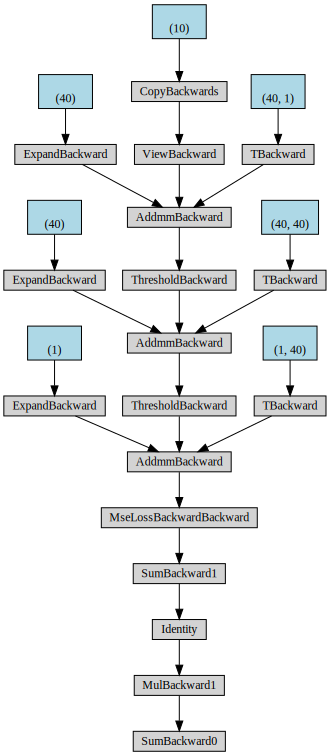

In [17]:
make_dot(vjp)

In [18]:
theta = Variable(torch.randn(2,2), requires_grad=True)
f_of_theta = torch.sum(theta ** 2 + theta)
vector = Variable(torch.randn(2,2))

f_of_theta.backward(Variable(torch.ones(2,2), requires_grad=True), retain_variables=True)
gradient = theta.grad
gradient_vector_product = torch.sum(gradient * vector)
gradient_vector_product.backward(torch.ones(2,2))
hessian_vector_product = theta.grad - gradient

/Users/Mayank/anaconda2/envs/pytorch_src/lib/python2.7/site-packages/torch/autograd/__init__.py:92: UserWarning: retain_variables option is deprecated and will be removed in 0.3. Use retain_graph instead.
  warnings.warn("retain_variables option is deprecated and will be removed in 0.3. "


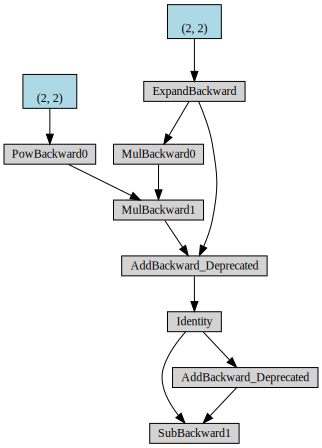

In [19]:
make_dot(hessian_vector_product)

In [125]:
losses = []
net = Net()
loss_criteria = nn.MSELoss()

In [126]:
def take_step():
    
    x, y = get_samples(10, show=False)
    
    output = net(x)
    loss = loss_criteria(output, y)
    print "\t Pre-train loss: ", loss.data[0]
#     losses.append(loss.data[0])
    
    # Compute d L(ftheta)/dtheta
    net.zero_grad()
    loss.backward(create_graph=True)
    
    # Update model parameters
    original_state = net.state_dict()
    for W in net.parameters():
        W.data.sub_(alpha*W.grad.data)
    
    updates = {}
    # Get parameters fro one step lookahead
    for j in xrange(meta_batch_size):
        x_new, y_new = get_samples(10, show=False)

        output_lookahead = net(x_new)
        loss = loss_criteria(output_lookahead, y_new)
        grad_lookahead = grad(loss, net.parameters(), create_graph=False)
        grad_lookahead = map(lambda x: Variable(x.data), grad_lookahead)

        for i, (n, W) in enumerate(net.named_parameters()):
            vjp = torch.sum(W.grad * grad_lookahead[i])
#             vjp.requires_grad = True
#             vjp.volatile = False

            hvp = grad(vjp, W, retain_graph=True)[0]

#             print "Param: ", n
#             print "W size: ",  W.size(), type(W)
#             print "Beta: ", beta, " Alpha: ", alpha
#             print "HVP size: ", hvp.size(), type(hvp)
#             print "Original size: ", original_state[n].size()
    
            temp = W.grad.data - alpha*hvp.data
            
            if n in updates:
                updates[n] += temp
            else:
                updates[n] = temp.clone()        
        
        for n, _ in net.named_parameters():
#             print "Param: ", n
#             print "Update: ", -1*beta*updates[n]
            
            original_state[n] -= beta*updates[n]

    net.load_state_dict(original_state)
    
    output = net(x)
    loss = loss_criteria(output, y)
    losses.append(loss.data[0])
    print "\tPost train loss: ", loss.data[0]

In [127]:
for i in xrange(10):
    print i, 
    take_step()

0 	 Pre-train loss:  0.0344468168914
	Post train loss:  0.0197637844831
1 	 Pre-train loss:  1.58689677715
	Post train loss:  1.39262127876
2 	 Pre-train loss:  0.343419760466
	Post train loss:  0.210094258189
3 	 Pre-train loss:  12.914812088
	Post train loss:  18.1120491028
4 	 Pre-train loss:  31.3476066589
	Post train loss:  5.14061641693
5 	 Pre-train loss:  5.20085048676
	Post train loss:  3.1657435894
6 	 Pre-train loss:  10.0887823105
	Post train loss:  8.91570663452
7 	 Pre-train loss:  2.43737697601
	Post train loss:  2.26397514343
8 	 Pre-train loss:  0.760227799416
	Post train loss:  0.48419418931
9 	 Pre-train loss:  12.450676918
	Post train loss:  11.2636814117


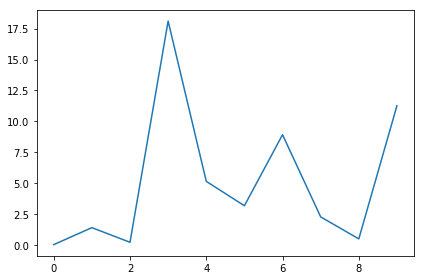

In [128]:
plt.figure()
plt.plot(range(len(losses)), losses)
plt.tight_layout()
plt.show()

In [129]:
losses

[0.019763784483075142,
 1.3926212787628174,
 0.21009425818920135,
 18.112049102783203,
 5.140616416931152,
 3.165743589401245,
 8.915706634521484,
 2.263975143432617,
 0.48419418931007385,
 11.263681411743164]

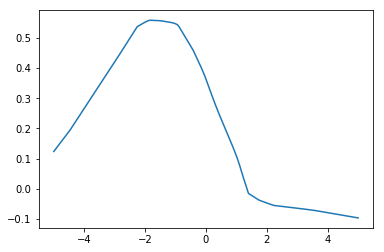

In [130]:
x_test = Variable(torch.linspace(-5, 5, steps=1000), requires_grad=True)
y = net(x_test)

plt.plot(x_test.data.numpy(), y.data.numpy())